**Descripción del Cuaderno**

Este cuaderno está diseñado para trabajar con modelos de aprendizaje automático utilizando TensorFlow y otras bibliotecas relevantes.

1. **Instalación y Configuración**: Desinstala versiones anteriores de TensorFlow y `tf-keras` e instala TensorFlow 2.15.0.

2. **Importación de Librerías**: Incluye `sklearn` para herramientas de machine learning, `tensorflow` y `keras` para aprendizaje profundo, `numpy` para operaciones numéricas, `os` para manejo de archivos, y `matplotlib` para visualización.

3. **Configuración del Entorno**: Establece semillas para reproducibilidad y configura Matplotlib para mostrar gráficos en línea con tamaños de fuente específicos.

4. **Configuración de Directorios y Funciones para Guardar Figuras**: Define el directorio para guardar imágenes y funciones para guardar figuras y trazar imágenes.

5. **Carga y Preprocesamiento de Datos**: Carga el conjunto de datos Fashion MNIST, normaliza los valores de los píxeles y divide el conjunto de entrenamiento en datos de entrenamiento y validación.

6. **Definición de Métricas y Funciones de Ajuste de Tasa de Aprendizaje**: Incluye una métrica personalizada para precisión redondeada y funciones para ajustar la tasa de aprendizaje.

7. **Funciones para Visualización de Reconstrucciones**: Visualiza las reconstrucciones generadas por el modelo comparadas con las imágenes originales.

8. **Evaluación de Modelos**: Evalúa el modelo en el conjunto de prueba y muestra gráficos de pérdida y precisión durante el entrenamiento.

9. **Definición de Clases y Funciones para Autoencoders Variacionales**: Incluye una función de pérdida escalada y una capa de muestreo para autoencoders variacionales.

10. **Evaluación Avanzada del Discriminador**: Evalúa el discriminador de un GAN generando imágenes falsas y reales, y calcula métricas de rendimiento como la curva ROC y la matriz de confusión.

11. **Instalación de Paquetes Adicionales**: Instala paquetes adicionales para la generación de GIFs y documentación de TensorFlow.

In [1]:
!pip uninstall -y tensorflow tf-keras
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: tf_keras 2.17.0
Uninstalling tf_keras-2.17.0:
  Successfully uninstalled tf_keras-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully u

In [2]:


import sklearn
import tensorflow as tf
from tensorflow import keras


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
# Cargar los datos
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalizar los datos
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# Dividir los datos en entrenamiento y validación
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Agregar la dimensión del canal
X_train = np.expand_dims(X_train, axis=-1)  # Agrega la dimensión de canal
X_valid = np.expand_dims(X_valid, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
import matplotlib.pyplot as plt
import tensorflow as tf

def evaluar_modelo(history, model, X_test):
    # Evaluar el modelo en los datos de prueba
    resultado = model.evaluate(X_test, X_test, verbose=0)
    print(f'Evaluación con test: Loss= {resultado[0]}, Acc= {resultado[1]}')

    # Crear una figura con dos subplots
    plt.figure(figsize=(12, 5))

    # Subplot 1: Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Error')
    plt.legend()

    # Subplot 2: Precisión (accuracy)
    if 'rounded_accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['rounded_accuracy'], label='Acc')
        plt.plot(history.history['val_rounded_accuracy'], label='Val Acc')
        plt.title('Precisión durante el entrenamiento')
        plt.xlabel('Épocas')
        plt.ylabel('Acc')
        plt.legend()

    # Mostrar las gráficas
    plt.show()

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K

# Definición de ScaledBinaryCrossentropy y Sampling
class ScaledBinaryCrossentropy(keras.losses.Loss):
    def __init__(self, scale):
        super(ScaledBinaryCrossentropy, self).__init__()
        self.scale = scale

    def call(self, y_true, y_pred):
        return self.scale * tf.keras.losses.mae(y_true, y_pred)

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
!pip install tf-keras-vis
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(42)
np.random.seed(42)

def plot_cam(layer_name, image, target_class, ax, max_value,min_value, model_for_gradcam, gradcam):
    """
    Genera y plotea el CAM para una imagen dada y una clase objetivo.
    """
    # Ajustar la imagen a la forma correcta si es necesario
    image = image.reshape(1, 28, 28,1)

    # Generar el CAM con GradCAM++ usando la capa especificada
    cam = gradcam(CategoricalScore(target_class), image, penultimate_layer=layer_name, normalize_cam=False)
    avg_intensity = np.mean(cam[0])

    # Plotear la imagen original
    img = ax.imshow(image.squeeze(), cmap='binary')

    # Superponer el CAM como un mapa de calor
    heatmap = ax.imshow(cam[0], cmap='jet',alpha=0.5, vmin=min_value, vmax=max_value)  # Ajustar el rango con vmin y vmax

    # Configuración de la gráfica
    ax.set_title(round(avg_intensity,2))
    ax.axis('off')
    return heatmap

def generate_and_plot_cam_for_output(model, X_test, y_test, layers, output_name, class_mode=True):
    """
    Genera y plotea CAMs para cada capa y salida especificada.

    Args:
        model: Modelo de Keras con el que se generarán los CAMs.
        X_test: Imágenes de prueba.
        y_test: Etiquetas de prueba.
        layers: Lista de nombres de capas para las que se generarán los CAMs.
        output_name: Nombre de la salida que se desea analizar ('classifier', 'reconstruction', 'dkl_loss').
        class_mode: Si es True, generará CAMs para cada clase; si es False, mostrará el valor del CAM para la imagen dada.
    """
    # Configuración para obtener el modelo para GradCAM++
    model_for_gradcam = Model(inputs=model.input, outputs=model.get_layer(output_name).output)
    gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

    # Recorrer cada capa
    for layer in layers:
        print(f'Capa: {layer}')
        for class_label in range(10):
            # Obtener el índice de la primera imagen de la clase actual
            index = np.where(y_test == class_label)[0][0]

            # Configuración de la figura para las 10 clases si estamos en modo clasificación
            if class_mode and output_name == 'classifier':
                fig, axes = plt.subplots(1, 10, figsize=(20, 2))
                # Calcular el valor máximo de los CAMs para esta capa y clase
                cams = [gradcam(CategoricalScore(target_class), X_test[index].reshape(1, 28, 28,1), penultimate_layer=layer, normalize_cam=False)[0] for target_class in range(10)]
                max_value = np.max(cams)
                min_value = np.min(cams)

                # Generar y mostrar los CAMs para cada clase
                heatmaps = []
                for target_class in range(10):
                    ax = axes[target_class]
                    heatmap = plot_cam(layer, X_test[index], target_class, ax, max_value,min_value, model_for_gradcam, gradcam)
                    heatmaps.append(heatmap)

                # Añadir una colorbar común para esta fila de imágenes
                fig.colorbar(heatmaps[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
                plt.show()
            else:
                # Modo para las otras salidas
                fig, ax = plt.subplots(1, 1, figsize=(5, 5))
                cam = gradcam(CategoricalScore(0), X_test[index].reshape(1, 28, 28,1), penultimate_layer=layer, normalize_cam=False)
                avg_intensity = np.mean(cam[0])
                ax.imshow(X_test[index].squeeze(), cmap='binary')
                ax.imshow(cam[0], cmap='jet', alpha=0.5)
                ax.set_title(f'{output_name}, Avg Intensity: {avg_intensity:.2f}')
                ax.axis('off')
                plt.show()
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc

def show_reconstructions(model, images=X_valid, n_images=5):
    """
    Muestra las imágenes originales y sus reconstrucciones generadas por el modelo.

    Parámetros:
    model: El modelo entrenado de autoencoder variacional.
    images: Las imágenes de entrada para generar las reconstrucciones (por defecto, X_valid).
    n_images: Número de imágenes a mostrar.
    """
    # Obtener las reconstrucciones del modelo
    reconstructions = model.predict(images[:n_images])['reconstruction']

    # Crear una figura con subplots para mostrar las imágenes
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        # Mostrar imagen original
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        # Mostrar imagen reconstruida
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

def plot_multiple_images(images, n_cols=None):
    """
    Muestra múltiples imágenes en una cuadrícula.

    Parámetros:
    images: Lista de imágenes a mostrar.
    n_cols: Número de columnas en la cuadrícula. Si es None, se usa el número de imágenes.
    """
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    # Eliminar el canal si es unidimensional
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def evaluar_modelo(history, model, X_test, y_test, num_classes=10):
    """
    Evalúa el modelo y muestra las métricas y gráficas de desempeño.

    Parámetros:
    history: Historial del entrenamiento del modelo.
    model: El modelo entrenado de autoencoder variacional.
    X_test: Datos de entrada de prueba.
    y_test: Etiquetas de prueba.
    num_classes: Número de clases en la salida de clasificación.
    """
    # Obtener las predicciones del modelo
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs['classifier'], axis=1)

    # Calcular la precisión de clasificación usando accuracy_score
    accuracy = accuracy_score(y_test, y_pred)

    # Evaluar el modelo en los datos de prueba usando model.evaluate
    resultado = model.evaluate(X_test, {"reconstruction": X_test, "dkl_loss": np.zeros((X_test.shape[0],)), "classifier": y_test}, verbose=0)
    print(f'Evaluación con test: Reconstruction Loss = {resultado[1]}, DKL Loss = {resultado[2]}, Classification Accuracy = {accuracy:.4f}')

    # Crear una figura con dos subplots para mostrar la pérdida y precisión
    plt.figure(figsize=(18, 5))

    # Subplot 1: Pérdida (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.plot(history.history['val_reconstruction_loss'], label='Val Reconstruction Loss')
    plt.plot(history.history['dkl_loss_loss'], label='DKL Loss')
    plt.plot(history.history['val_dkl_loss_loss'], label='Val DKL Loss')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Error')
    plt.legend()

    # Subplot 2: Precisión (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['encoder_accuracy'], label='Training Classification Accuracy')
    plt.plot(history.history['val_encoder_accuracy'], label='Validation Classification Accuracy')
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Mostrar las gráficas
    plt.show()

def evaluate_classifier(test_images, test_labels, model, num_classes=10):
    """
    Evalúa el rendimiento del clasificador, incluyendo la curva ROC y la matriz de confusión.

    Parámetros:
    test_images: Imágenes de prueba.
    test_labels: Etiquetas de prueba.
    model: El modelo clasificador.
    num_classes: Número de clases en la salida de clasificación.
    """
    # Obtener las predicciones del modelo
    y_pred_probs = model.predict(test_images)
    y_pred = np.argmax(y_pred_probs['classifier'], axis=1)

    # Calcular la curva ROC y el AUC para cada clase
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels == i, y_pred_probs['classifier'][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(test_labels, y_pred, normalize='true')

    # Configuración de la figura con dos gráficos (ROC y matriz de confusión)
    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 8))

    # Graficar la curva ROC para cada clase
    for i in range(num_classes):
        ax1.plot(fpr[i], tpr[i], lw=2, label=f'{i}')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right")

    # Graficar la matriz de confusión normalizada
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[f'{i}' for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues, ax=ax2, colorbar=True)
    ax2.set_title('Normalized Confusion Matrix')

    plt.show()

    # Calcular las métricas y generar el reporte de clasificación
    precision = precision_score(test_labels, y_pred, average='weighted')
    recall = recall_score(test_labels, y_pred, average='weighted')
    f2 = fbeta_score(test_labels, y_pred, beta=2, average='weighted')

    # Imprimir las métricas de precisión, recall y F2-score
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2-score: {f2:.4f}")

    # Generar e imprimir el reporte de clasificación
    report = classification_report(test_labels, y_pred, target_names=[f'{i}' for i in range(num_classes)])
    print(report)



4422102/4422102 [==============================] - 1s 0us/step
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.3 MB/s eta 0:00:00


# Modelo

**Descripción del Código**

1. **Configuración Inicial**:
   - Se configuran semillas para reproducibilidad en TensorFlow y NumPy.
   - Se definen parámetros para la función de pérdida y el tamaño de los codificadores.
   - `losses` define la función de pérdida escalada para el autoencoder variacional.

2. **Definición de la Arquitectura del Modelo**:
   - **Encoder**:
     - Se construye con capas convolucionales seguidas de `MaxPooling` para extraer características y reducir la dimensionalidad.
     - Utiliza `LeakyReLU` como función de activación.
     - Finalmente, las características extraídas se aplanan y se pasan a través de capas densas para obtener las medias (`codings_mean`) y logaritmos de varianzas (`codings_log_var`) de las codificaciones.
     - La capa `Sampling` genera las codificaciones finales a partir de estas medias y varianzas.
     - Se añade una capa densa para la salida de clasificación (`classifier_output`), con activación `softmax` para clasificación en múltiples clases.

   - **Decoder**:
     - Comienza con una capa densa que expande las codificaciones a una forma adecuada para la reconstrucción.
     - Utiliza capas `Conv2DTranspose` para reconstruir la imagen original desde las codificaciones.
     - Se aplican `BatchNormalization` y `LeakyReLU` después de cada capa convolucional transpuesta.

3. **Definición de Modelos**:
   - `variational_encoder` es el modelo del encoder que toma las imágenes de entrada y produce las codificaciones y la salida de clasificación.
   - `variational_decoder` es el modelo del decoder que toma las codificaciones y produce las imágenes reconstruidas.

4. **Pérdida DKL (Kullback-Leibler Divergence)**:
   - Se calcula la pérdida DKL como una métrica adicional y se normaliza.
   - `dkl_output` es la salida de la pérdida DKL que se usa en la compilación del modelo.

5. **Compilación del Modelo**:
   - `variational_ae` combina el encoder y el decoder en un solo modelo con tres salidas: reconstrucción, pérdida DKL y salida de clasificación.
   - Se compila el modelo con las pérdidas definidas para cada salida y se usa la métrica de precisión para la salida de clasificación.

6. **Entrenamiento del Modelo**:
   - El modelo se entrena utilizando `X_train` y `y_train` para las imágenes y las etiquetas, respectivamente.
   - Se realiza la validación utilizando `X_valid` y `y_valid` con las mismas pérdidas y métricas definidas para la validación.

Este código define y entrena un autoencoder variacional con capacidades de clasificación, utilizando un encoder y un decoder para la reconstrucción de imágenes y la clasificación de etiquetas.

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy
{
    +
}
# Configuración de semillas para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

# Parámetros para la función de pérdida
alpha = 15
betha = 1 - alpha
losses = ScaledBinaryCrossentropy(5)  # Define la función de pérdida escalada

# Tamaño de los codificadores y número de clases
codings_size = 300
num_classes = 10  # Número de clases para la salida de clasificación (por ejemplo, para MNIST)

# Programador de tasa de aprendizaje con cambios a intervalos específicos
piecewise_constant_fn = piecewise_constant([120, 30], [1e-3, 1e-4])
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

# Entrada de la red neuronal
inputs = keras.layers.Input(shape=[28, 28, 1], name="input")

# Encoder
z = keras.layers.Conv2D(64, kernel_size=3, padding="same", name='Conv1')(inputs)
z = keras.layers.MaxPooling2D(pool_size=2)(z)
z = tf.keras.layers.LeakyReLU()(z)
z = keras.layers.Conv2D(128, kernel_size=3, padding="same", name='Conv2')(z)
z = keras.layers.MaxPooling2D(pool_size=2)(z)
z = tf.keras.layers.LeakyReLU()(z)
z = keras.layers.Conv2D(256, kernel_size=3, padding="same", name='Conv3')(z)
z = keras.layers.MaxPooling2D(pool_size=2)(z)
z = tf.keras.layers.LeakyReLU(name='Capa_h')(z)
z = keras.layers.Flatten()(z)
z = keras.layers.Dense(400)(z)
z = tf.keras.layers.LeakyReLU()(z)
codings_mean = keras.layers.Dense(codings_size, kernel_constraint=tf.keras.constraints.UnitNorm(), name="codings_mean")(z)
codings_log_var = keras.layers.Dense(codings_size, kernel_constraint=tf.keras.constraints.UnitNorm(), name="codings_log_var")(z)
codings = Sampling(name="codings")([codings_mean, codings_log_var])
classifier_output = keras.layers.Dense(num_classes, activation='softmax', name='classifier')(codings)

# Decoder
decoder_inputs = keras.layers.Input(shape=[codings_size], name="decoder_input")
x = keras.layers.Dense(7 * 7 * 64)(decoder_inputs)
x = tf.keras.layers.LeakyReLU()(x)
x = keras.layers.Reshape([7, 7, 64])(x)
x = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", name='ConvT1')(x)
x = keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", name='ConvT2')(x)
x = keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2DTranspose(16, kernel_size=3, strides=1, padding="same", name='ConvT3')(x)
x = keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
outputs = keras.layers.Conv2DTranspose(1, kernel_size=3, padding="same", activation="sigmoid")(x)

# Modelos
variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings, classifier_output], name="encoder")
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs], name="reconstruction")

# Generación de reconstrucciones a partir de codificaciones
_, _, codings, classifier_output = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

# Pérdida DKL como salida adicional
latent_loss = -alpha * 0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
dkl_output = K.mean(latent_loss) / 784.0
dkl_output = keras.layers.Lambda(lambda x: x, name="dkl_loss")(dkl_output)

# Definición del modelo de autoencoder variacional con tres salidas nombradas
variational_ae = keras.models.Model(inputs=inputs, outputs={"reconstruction": reconstructions, "dkl_loss": dkl_output, "classifier": classifier_output})

# Compilación del modelo con pérdidas y métricas nombradas
variational_ae.compile(loss={"reconstruction": losses, "dkl_loss": lambda y_true, y_pred: y_pred, "classifier": "sparse_categorical_crossentropy"},
                       optimizer="adam",
                       metrics={"classifier": ["accuracy"]})  # Solo se usa la métrica de precisión para el clasificador

# Entrenamiento del modelo
history = variational_ae.fit(X_train, {"reconstruction": X_train, "dkl_loss": np.zeros((X_train.shape[0],)), "classifier": y_train},
                             epochs=150, batch_size=256,
                             validation_data=(X_valid, {"reconstruction": X_valid, "dkl_loss": np.zeros((X_valid.shape[0],)), "classifier": y_valid}),
                             callbacks=[lr_scheduler])


Epoch 1/150
215/215 [==============================] - 35s 62ms/step - loss: 1.7174 - encoder_loss: 0.7264 - dkl_loss_loss: 0.2830 - reconstruction_loss: 0.7080 - encoder_accuracy: 0.7532 - val_loss: 1.4213 - val_encoder_loss: 0.4766 - val_dkl_loss_loss: 0.3009 - val_reconstruction_loss: 0.6439 - val_encoder_accuracy: 0.8392 - lr: 0.0010
Epoch 2/150
215/215 [==============================] - 10s 46ms/step - loss: 1.2383 - encoder_loss: 0.4236 - dkl_loss_loss: 0.2718 - reconstruction_loss: 0.5429 - encoder_accuracy: 0.8594 - val_loss: 1.2195 - val_encoder_loss: 0.3912 - val_dkl_loss_loss: 0.2685 - val_reconstruction_loss: 0.5599 - val_encoder_accuracy: 0.8740 - lr: 0.0010
Epoch 3/150
215/215 [==============================] - 10s 48ms/step - loss: 1.1666 - encoder_loss: 0.3685 - dkl_loss_loss: 0.2718 - reconstruction_loss: 0.5262 - encoder_accuracy: 0.8780 - val_loss: 1.1830 - val_encoder_loss: 0.3548 - val_dkl_loss_loss: 0.2843 - val_reconstruction_loss: 0.5440 - val_encoder_accuracy: 

##Evaluación del model

1/1 [==============================] - 1s 553ms/step


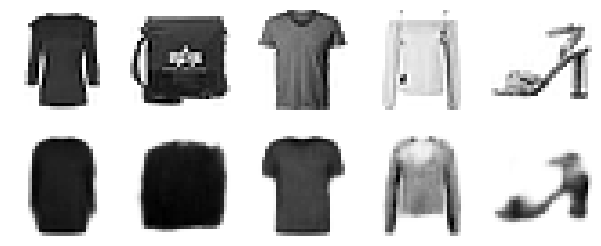

In [4]:



show_reconstructions(variational_ae)


Saving figure vae_generated_images_plot


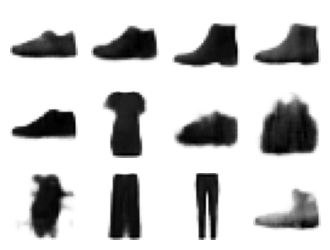

In [5]:
tf.random.set_seed(0)
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Saving figure semantic_interpolation_plot


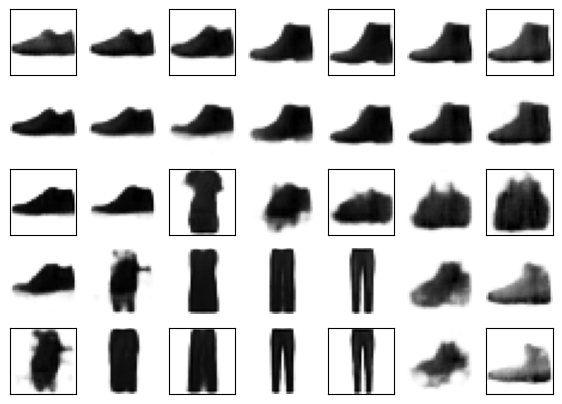

In [6]:
tf.random.set_seed(10)
np.random.seed(0)
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()
plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

## Curva de rendimiento

313/313 [==============================] - 4s 10ms/step
Evaluación con test: Reconstruction Loss = 0.4650917053222656, DKL Loss = 0.17948360741138458, Classification Accuracy = 0.9164


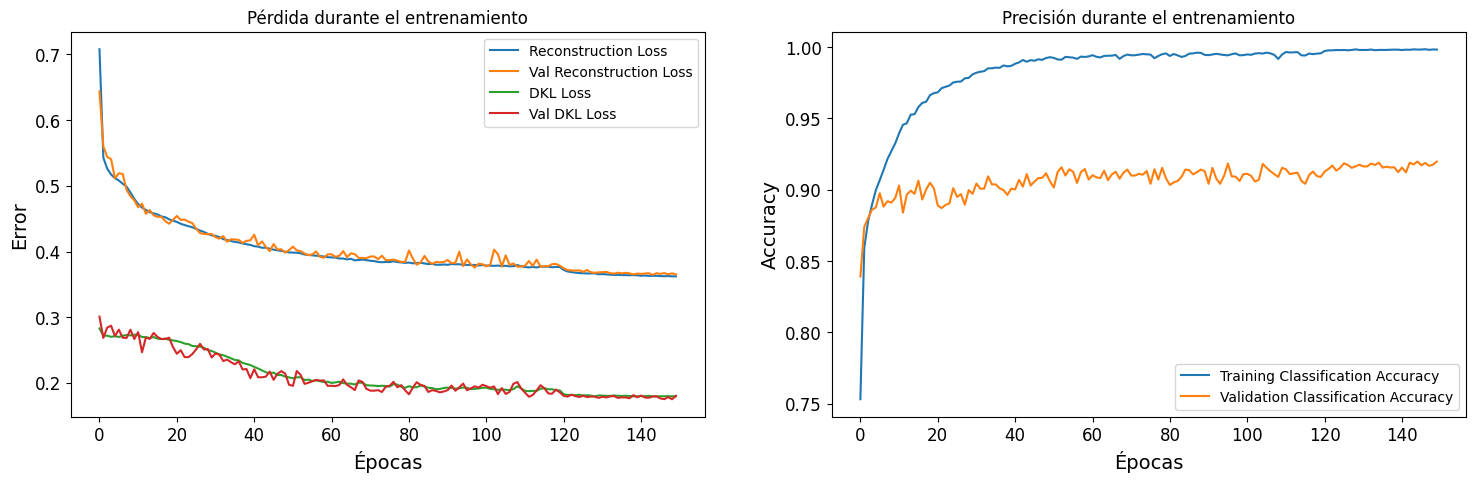

In [7]:
evaluar_modelo(history, variational_ae, X_test,y_test)


## matriz de confusión

313/313 [==============================] - 2s 6ms/step


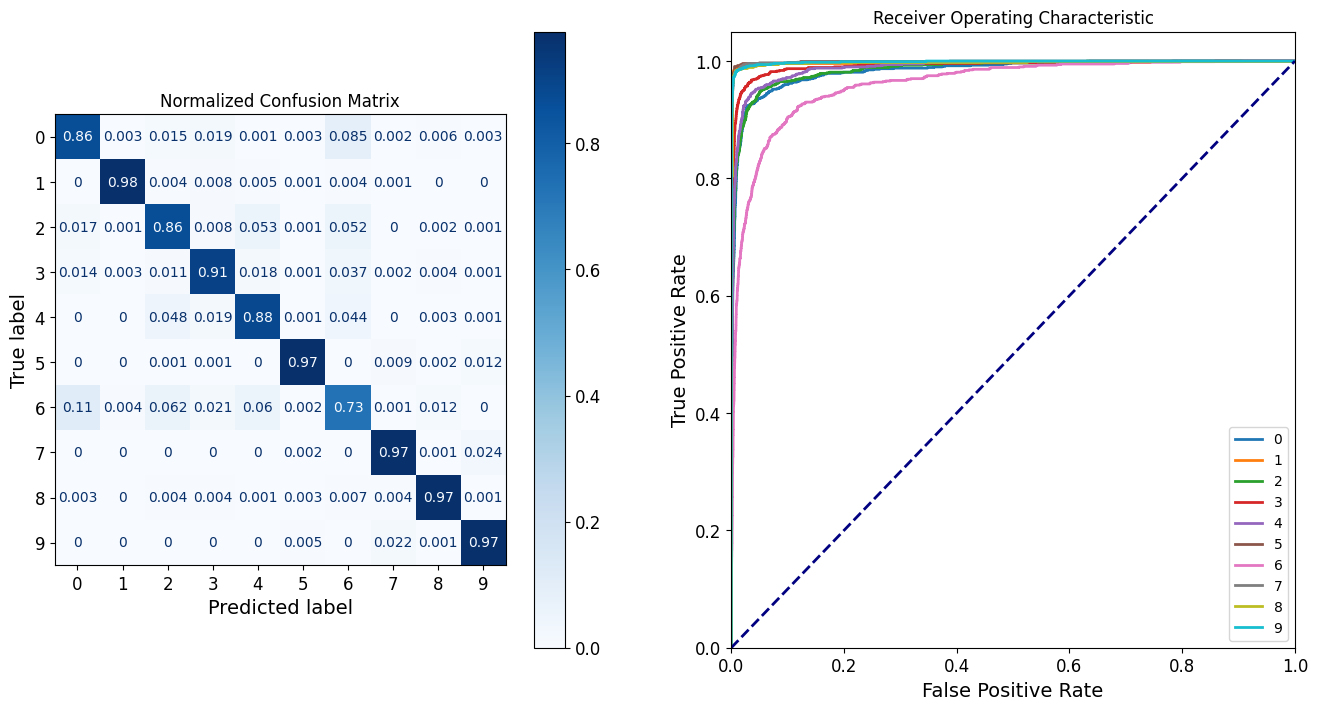

Precision: 0.9112
Recall: 0.9117
F2-score: 0.9116
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.99      0.98      0.98      1000
           2       0.86      0.86      0.86      1000
           3       0.92      0.91      0.91      1000
           4       0.86      0.88      0.87      1000
           5       0.98      0.97      0.98      1000
           6       0.76      0.73      0.74      1000
           7       0.96      0.97      0.97      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [8]:
evaluate_classifier(X_test, y_test, variational_ae)


## Espacio latente visto con TSNE

313/313 [==============================] - 2s 4ms/step


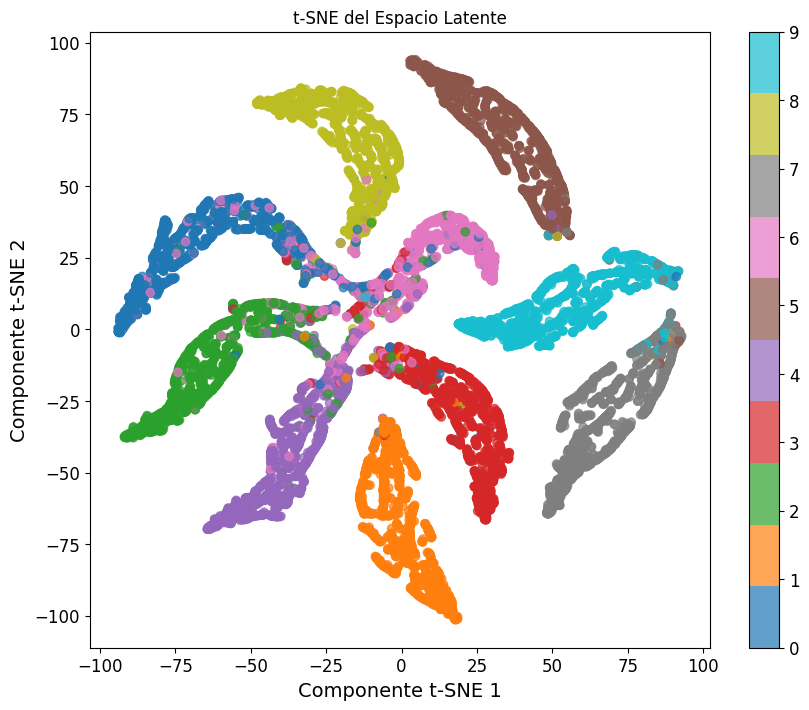

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Paso 1: Extraer el espacio latente
# Usamos el encoder para obtener los codings del espacio latente
_, _, _,codings = variational_encoder.predict(X_test)

# Paso 2: Aplicar t-SNE
# Reducimos a 2D para visualización
tsne = TSNE(n_components=2, random_state=42)
codings_2d = tsne.fit_transform(codings)

# Paso 3: Graficar con colores según las clases
plt.figure(figsize=(10, 8))
scatter = plt.scatter(codings_2d[:, 0], codings_2d[:, 1], c=y_test, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE del Espacio Latente")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.show()


## GradCam++

Capa: Conv1


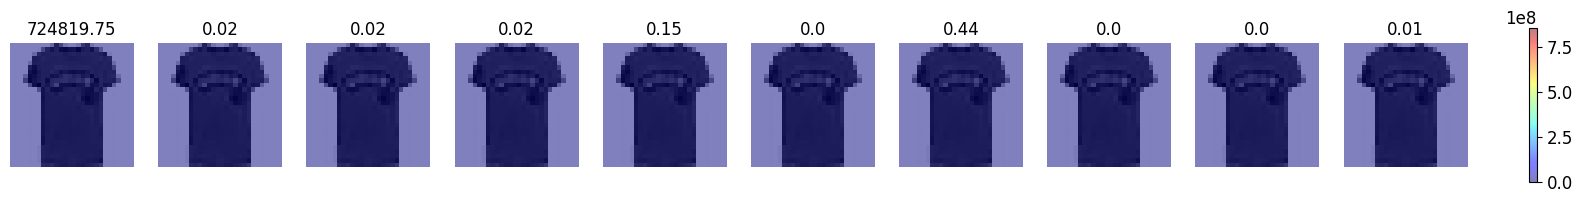

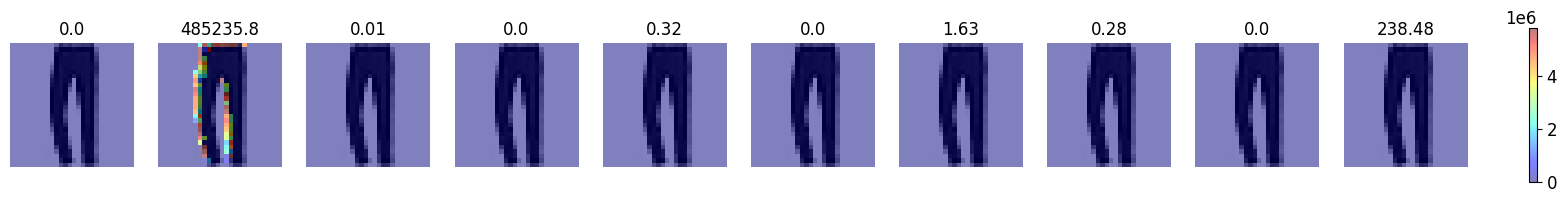

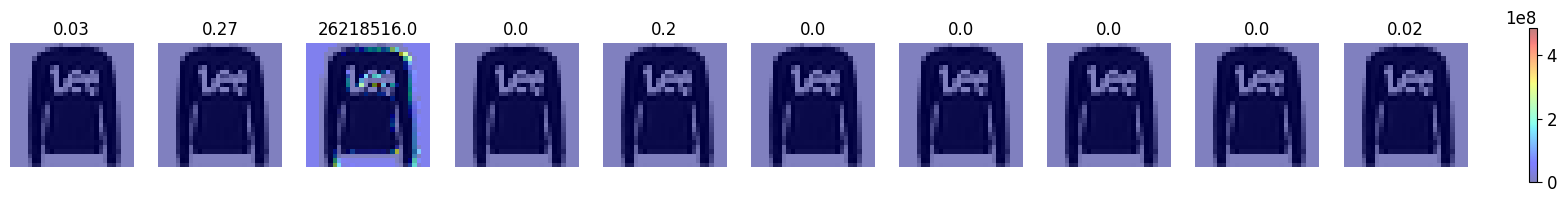

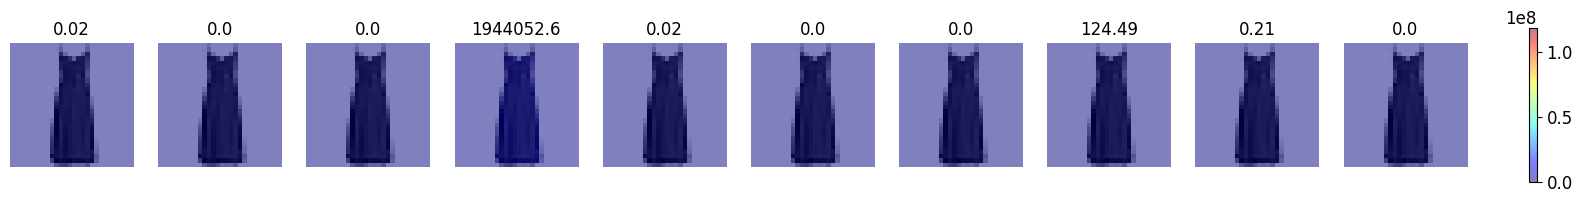

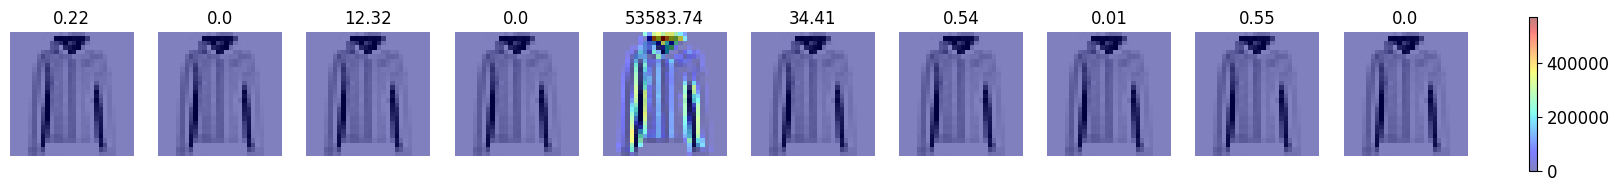

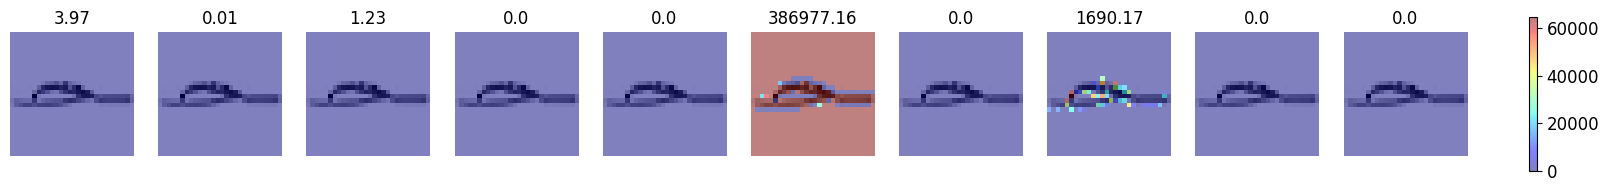

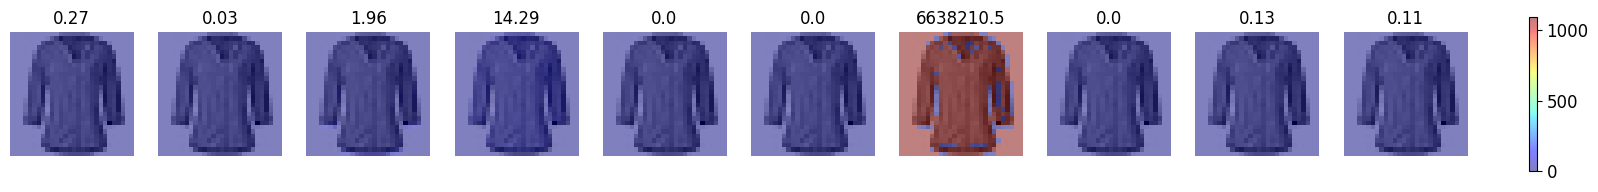

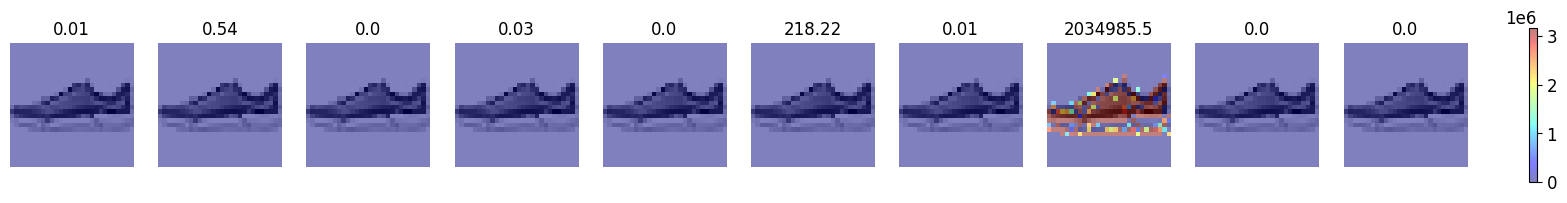

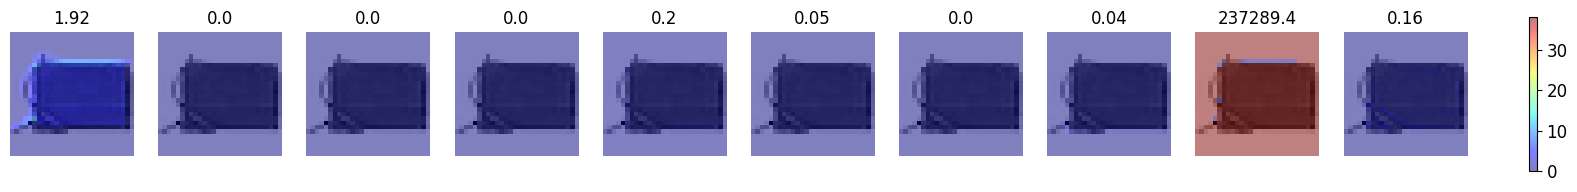

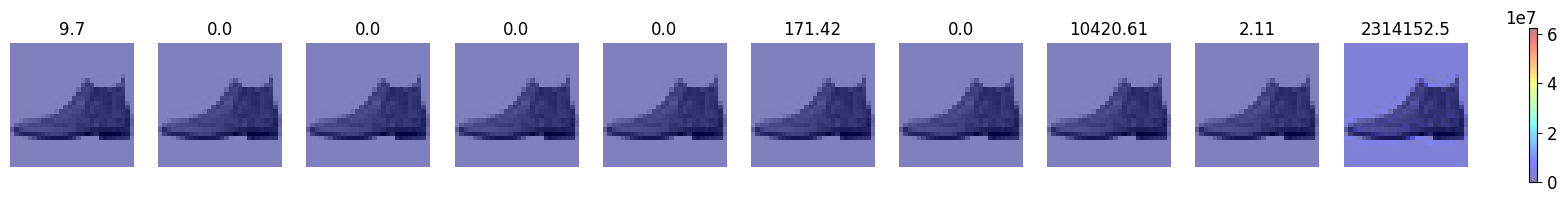

In [10]:
layers = ['Conv1']
generate_and_plot_cam_for_output(variational_encoder, X_test, y_test, layers, output_name='classifier', class_mode=True)


Capa: Conv2


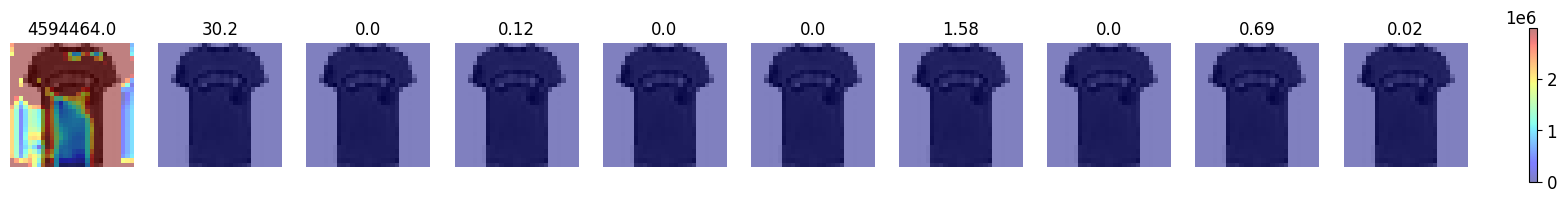

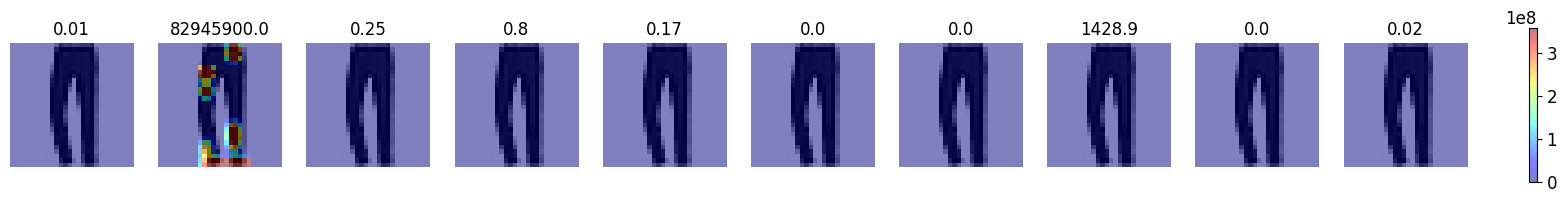

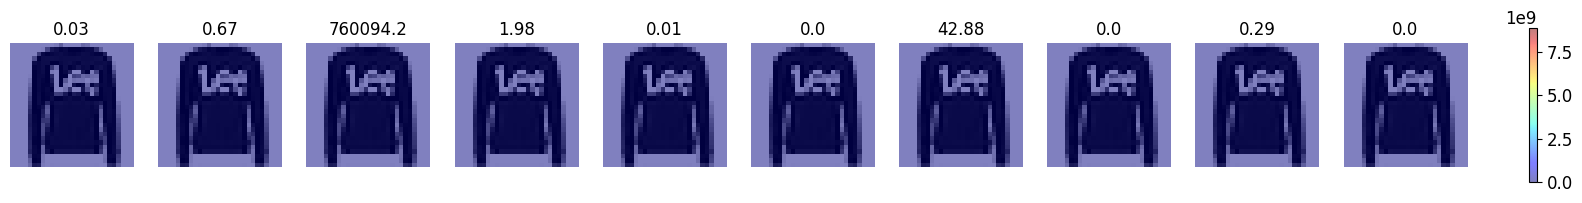

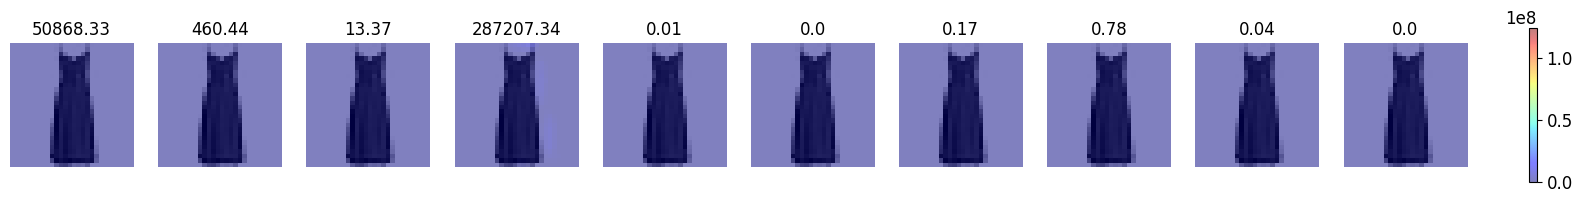

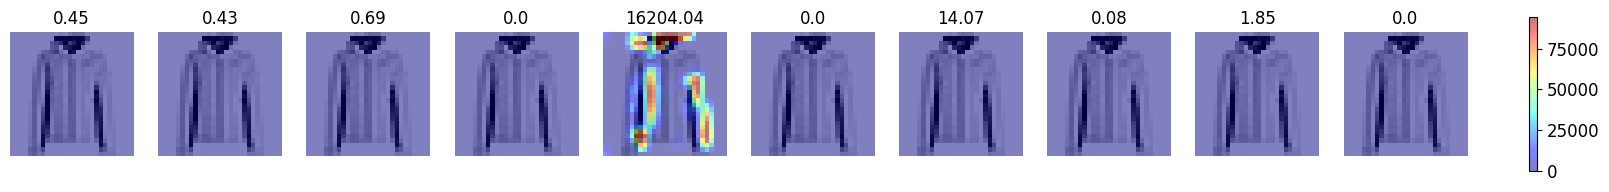

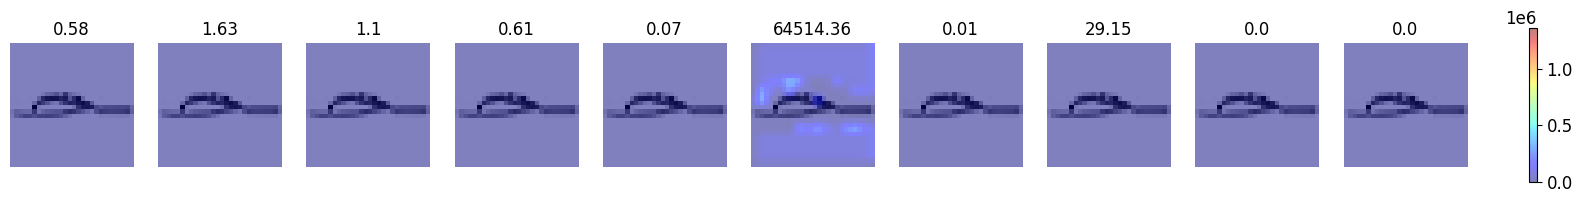

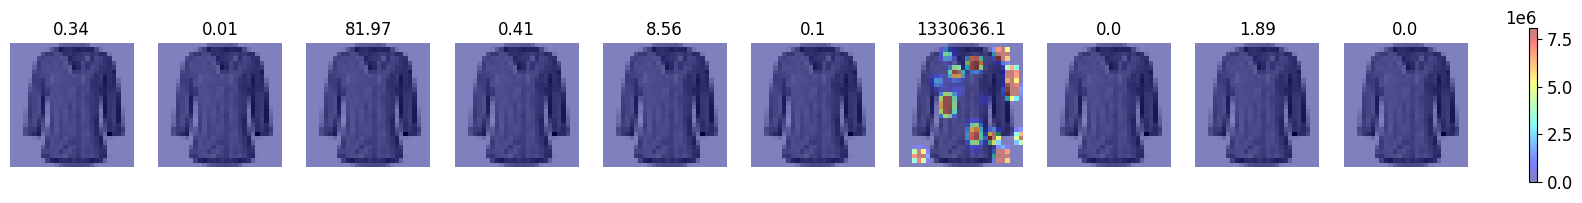

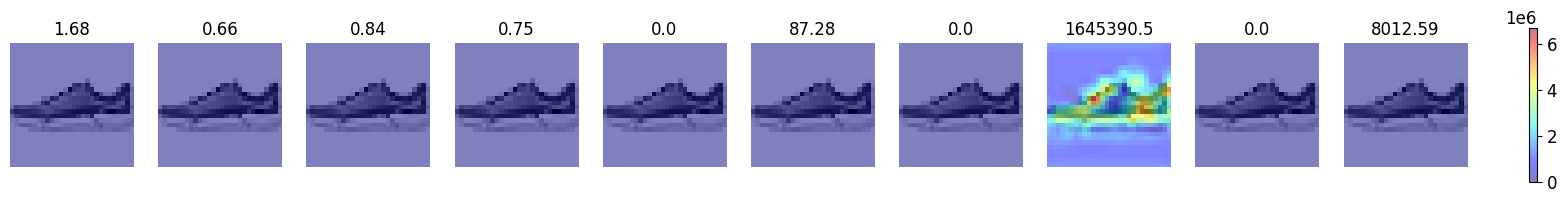

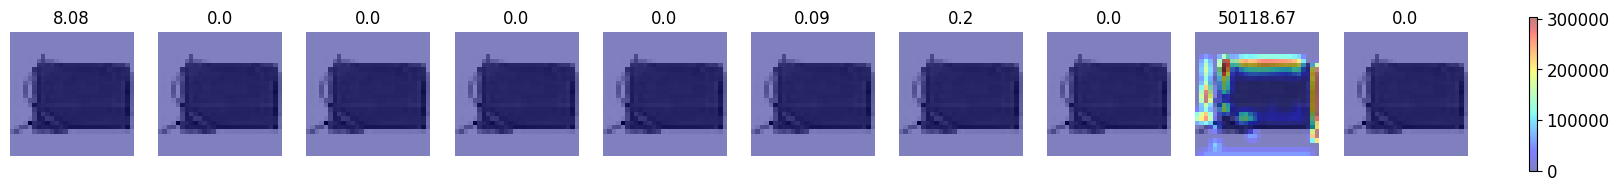

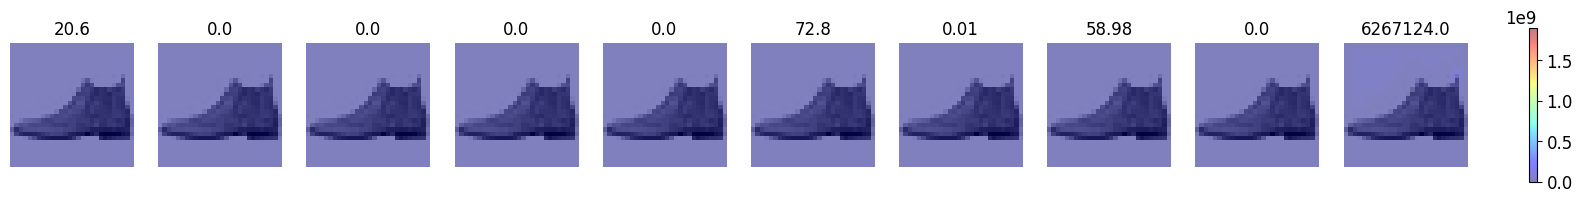

In [11]:
layers = ['Conv2']
generate_and_plot_cam_for_output(variational_encoder, X_test, y_test, layers, output_name='classifier', class_mode=True)


Capa: Conv3


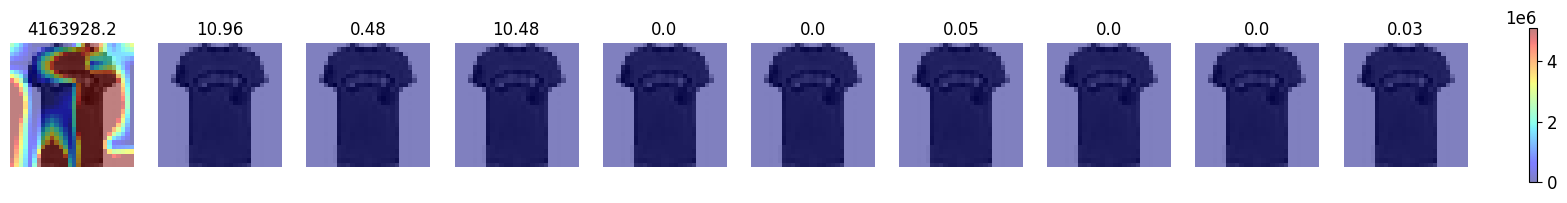

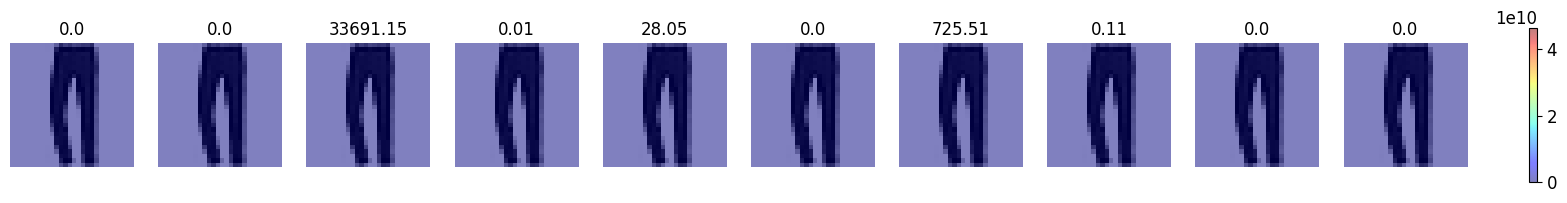

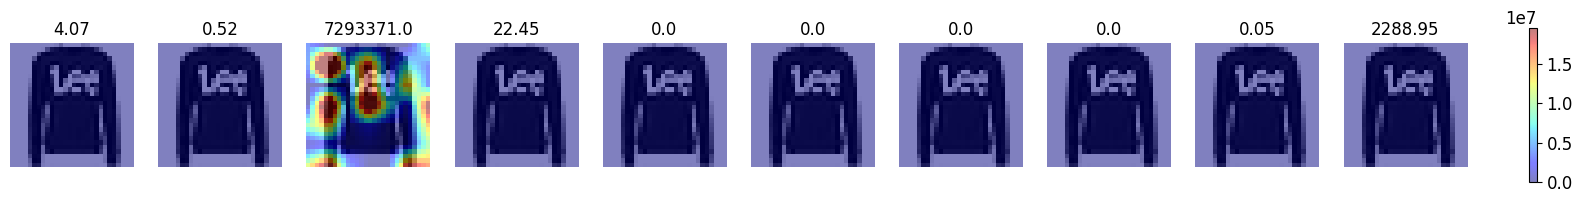

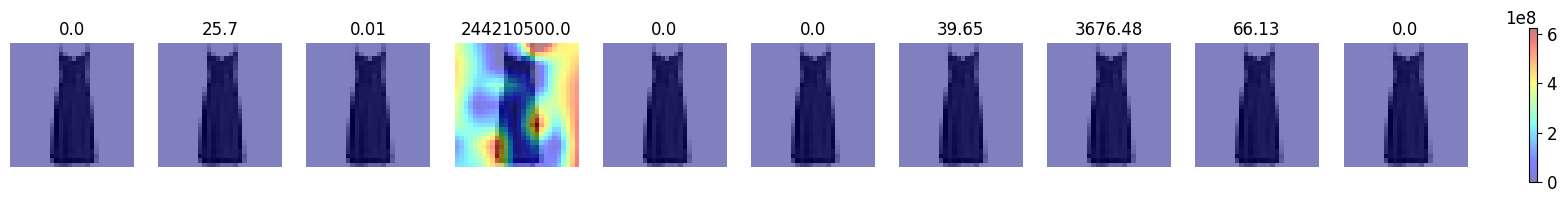

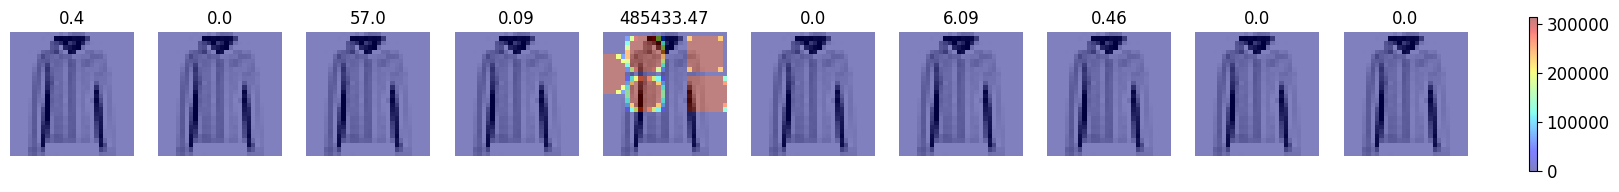

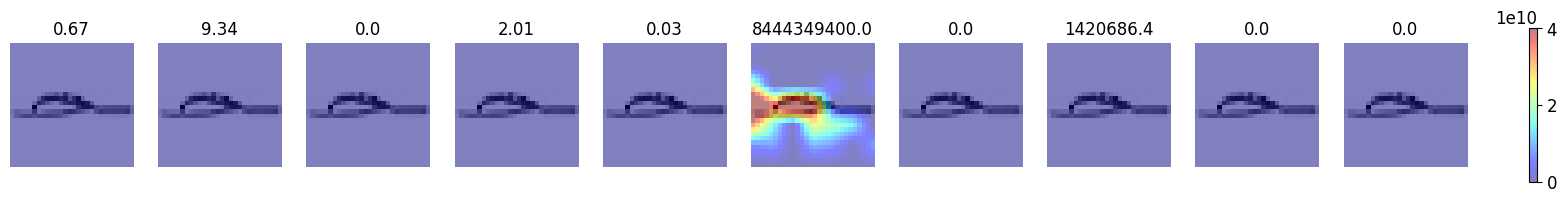

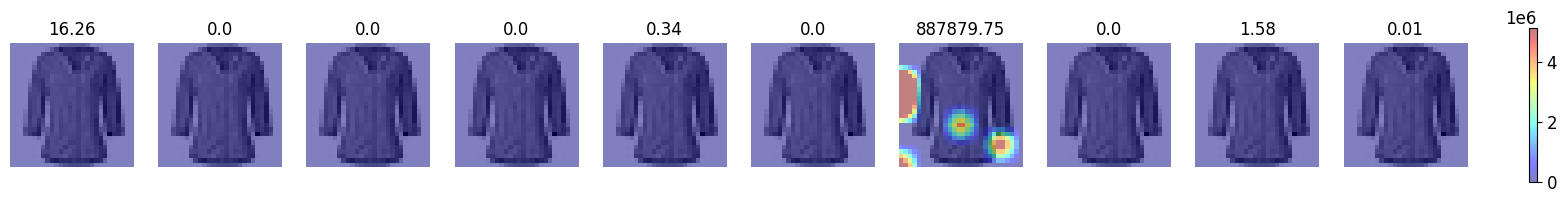

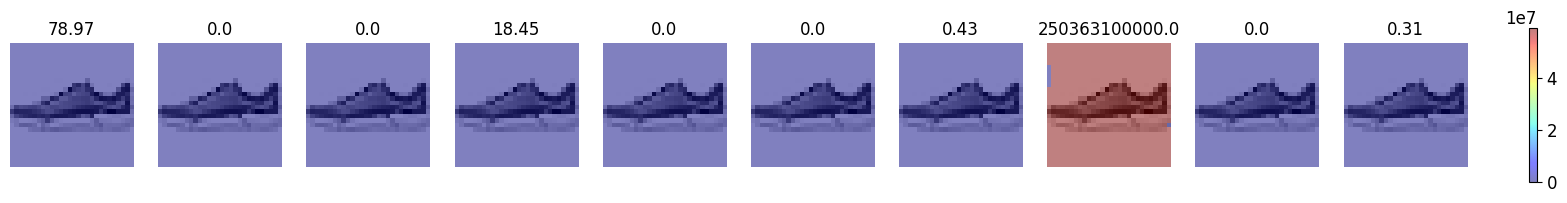

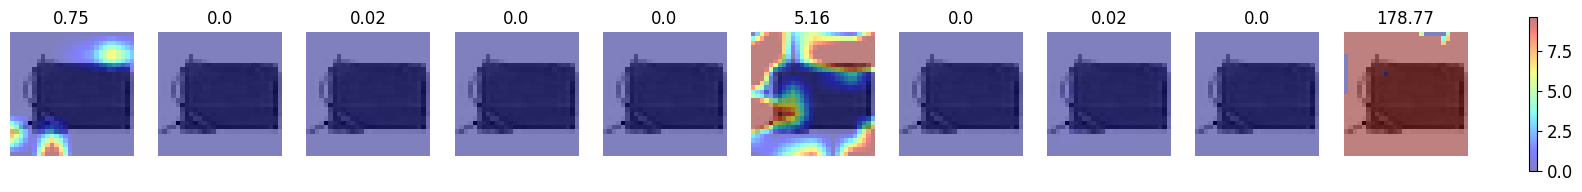

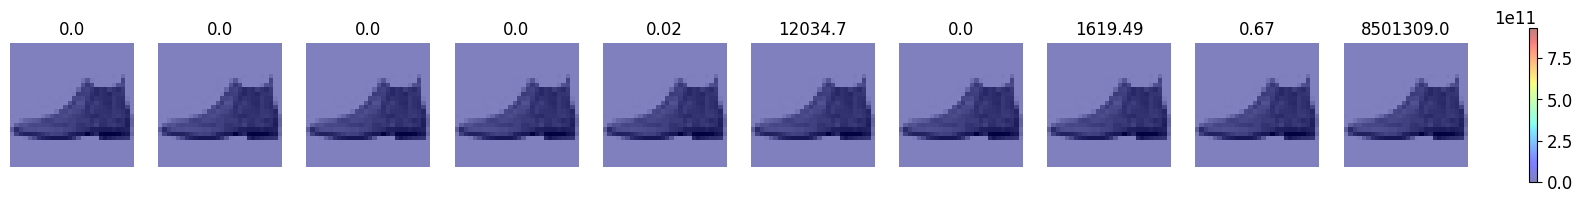

In [12]:
layers = ['Conv3']
generate_and_plot_cam_for_output(variational_encoder, X_test, y_test, layers, output_name='classifier', class_mode=True)


Capa: Capa_h


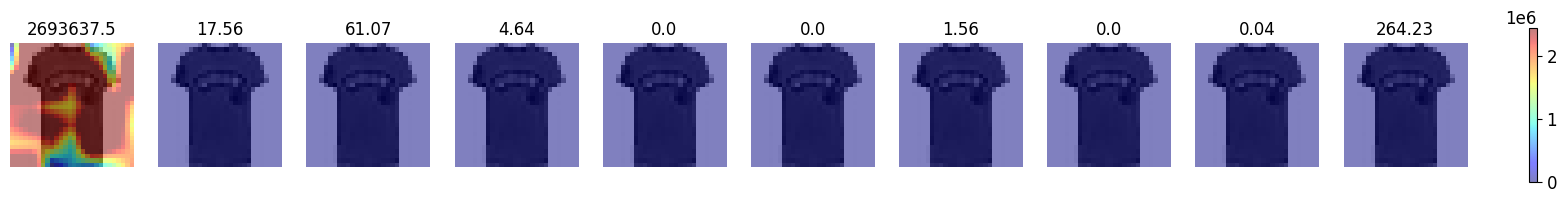

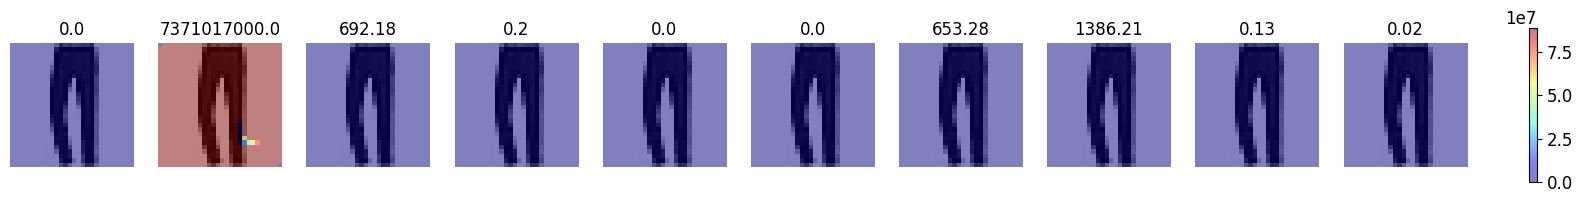

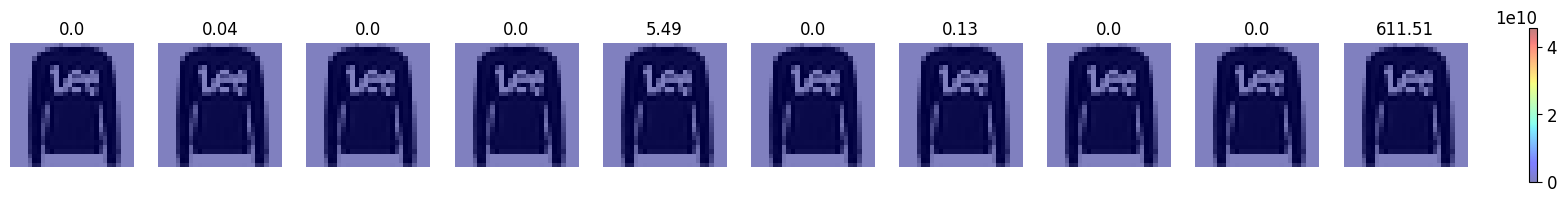

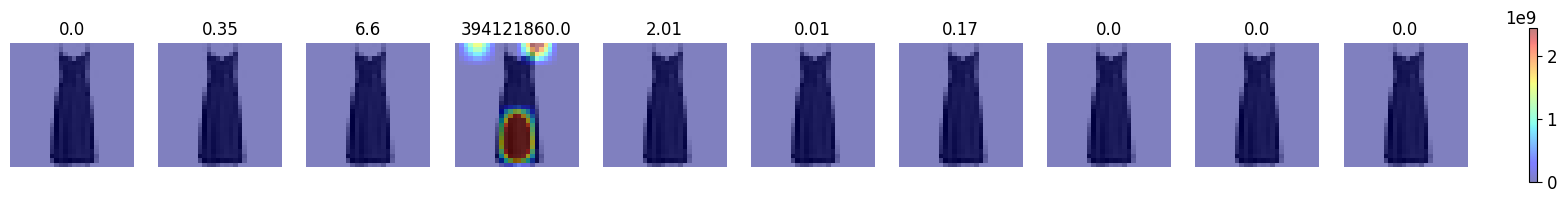

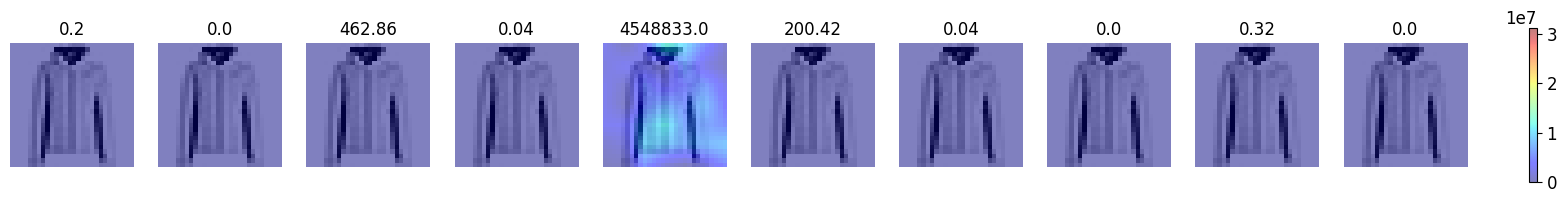

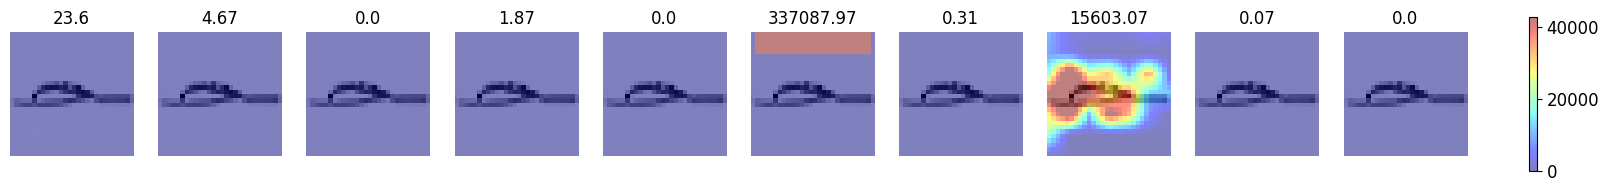

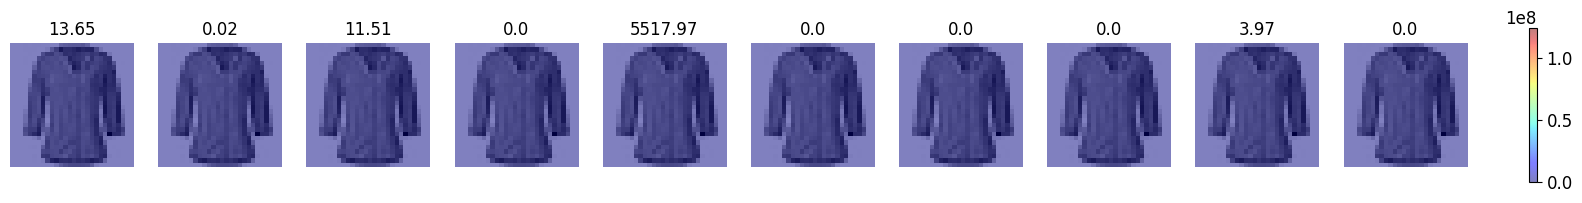

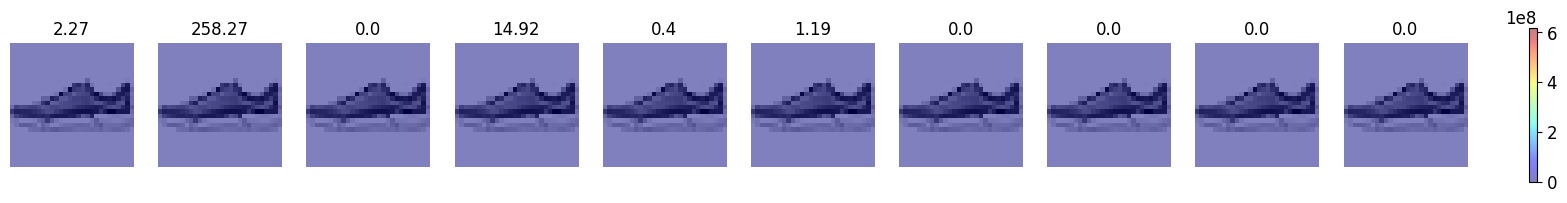

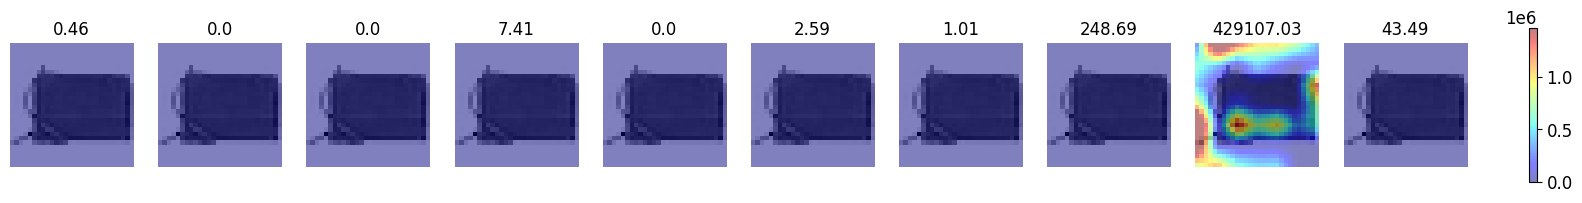

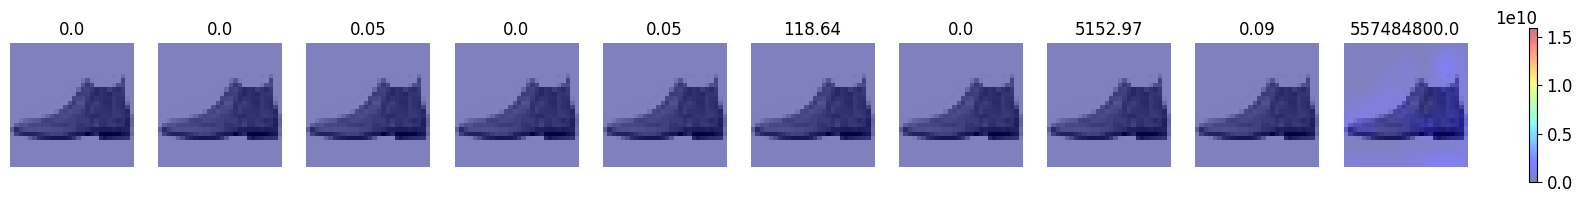

In [13]:
layers = ['Capa_h']
generate_and_plot_cam_for_output(variational_encoder, X_test, y_test, layers, output_name='classifier', class_mode=True)


# Conclusiones
Aunque el modelo presenta una tendencia al sobreajuste, evidente al observar la curva de accuracy, es importante destacar que el valor promedio de acierto alcanza el 90%, con algunas clases llegando incluso al 98%, según se refleja en la matriz de confusión y la curva ROC. En cuanto a la reconstrucción, se observa una ligera pérdida en el rendimiento debido a la adición de una tercera salida al modelo variacional. No obstante, en términos generales, para ser un modelo que no está diseñado específicamente para tareas de clasificación, los resultados obtenidos son aceptables.

En lo que respecta a los mapas de activación de clase (CAMs), se nota que en las primeras capas de Conv2D no se evidencia una clara separabilidad de los datos. Sin embargo, es importante señalar que entre la última capa Conv2D y la capa de clasificación existen tres capas densas, lo que sugiere que la detección de patrones importantes para la clasificación ocurre en las capas más profundas de la red. Este hecho se corrobora al analizar la capa de clasificación utilizando la técnica TSNE, donde se observa una clara diferenciación de las clases.